Sodelujoči

    Tomaž Štrus
    Anže Košir
    Jan Harej

O projektu: Iz platforme Steam, namenjenu predvsem za distrubicijo video iger, bomo zbrali podatke igrah več ljudi, ter analizirali stvari kot so npr. koliko iger, ki jih kupijo dejansko preigrajo, kolika časa bo nekdo zapravil za neko igro, kakšno igro bo kupil naslednjo, glede na svoje igre ipd.

Podatki: Uporabili bomo API, ki ga ponuja Steam: https://developer.valvesoftware.com/wiki/Steam_Web_API#JSON Tu lahko dobimo podatko o čisto vsemu kar potrebujemo npr. o uporabniku, njegove igre, prijatelji, koliko ur je igral neko igro, ... Dobili bomo podatke za npr. 100.000+ uporabnikov (prijatelji naših prijateljev, in njihov prijateljev itd.)

## Vprašanja za raziskavo
1. Povprečno dokončanje igre
2. Število in vrsta Bannov v povezavi z javnimi/privatnimi profili
3. Najmanjkrat odklenjeni dosežki za igrane igre
4. Število prijateljev glede na "starost" računa

In [ ]:
#install libraries on windows
"""
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install requests
"""

In [1]:
import requests
import json
import numpy
import datetime
import matplotlib.pyplot as plt
import os
import collections
from inspect import getouterframes, currentframe

In [2]:
api_key = "5F5DD2FA8A6C8646FCFE265C07BB90E5"
global_player_ids = set()
players_summaries = dict()
player_friends = dict()
player_games = dict()
player_games = dict()
player_achievements = dict()
my_id="76561198101569818"

In [ ]:
def get_player_summary (id):
    try:
        data = requests.get( "http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key="+api_key+"&steamids="+id).json()
    except:
        return None
    return data["response"]["players"][0]
    
def get_multiple_player_summary (ids):
    request_str = "http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key="+api_key+"&steamids="
    request_str += ",".join(ids)

    try:
        data = requests.get(request_str).json()
    except:
        return None
    return data["response"]["players"]
    

In [ ]:
def get_player_friends(id):
    try:
        data = requests.get( "http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key=" + api_key + "&steamid=" + str(id) + "&relationship=friend").json()["friendslist"]["friends"]
    except KeyError:
        return []
    return data

In [ ]:
def get_owned_games(id):
    try:
        data = requests.get( "http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=" + api_key + "&steamid=" + str(id)).json()["response"]
    except KeyError:
        return []
    return data

In [3]:
print(get_player_summary("76561198024756463"))

NameError: name 'get_player_summary' is not defined

In [ ]:
def get_achievements_for_player_game(id, appid):
    data = requests.get( "http://api.steampowered.com/ISteamUserStats/GetPlayerAchievements/v0001/?appid=" + str(appid) + "&key=" + api_key + "&steamid=" + str(id)).json()
    return data

In [ ]:
#get_achievements_for_player_game(my_id, 620)

In [ ]:
def fill_player_ids_rec(id, num = 1000, already_called = set()):
    global global_player_ids
    already_called.add(id)
    print("recursive call of id: " + id + "  len: " + str(len(global_player_ids)))
    try:
        if get_player_summary(id)["profilestate"] != 1:
            #print("not public")
            return None
    except KeyError:
        #print("not public key error")
        return None
    data = get_player_friends(id)
    tmp_id = set()
    for friend in data:
        if len(global_player_ids) >= num:
            print("enough friends")
            break
        tmp_id.add(friend["steamid"])
        global_player_ids.add(friend["steamid"])
        #print("len: "+ str(len(global_player_ids)))
        
    print("added my friends" + "  len: " + str(len(global_player_ids)))
    
    for playerid in tmp_id:
        if len(global_player_ids) >= num:
            break
        data = get_player_friends(playerid)
        for fof in data:
            if len(global_player_ids) >= num:
                print("enough friends")
                break
            global_player_ids.add(fof["steamid"])
        #print("added friends of friend")
            
    print("added friends of friends" + "  len: " + str(len(global_player_ids)))
    
    for playerid in tmp_id:
        if len(global_player_ids) >= num:
            print("enough friends")
            break
        if playerid not in already_called:
            fill_player_ids_rec(playerid, num, already_called)
    
    

In [ ]:
def fill_players_summaries():
    global global_player_ids
    global players_summaries
    
    player_ids = list(global_player_ids)
    for i in range(0, len(player_ids)+1, 100):
        tmp_summaries = get_multiple_player_summary(player_ids[i-100:i])
        for summary in tmp_summaries:
            #summary["friends"] = get_player_friends(summary["steamid"])
            players_summaries[summary["steamid"]] = summary
        

In [ ]:
def fill_players_friends():
    global player_friends
    global players_summaries
    for player in players_summaries.keys():
        player_friends[player] = get_player_friends(player)
        print(len(player_friends))
    print("done")

In [ ]:
def fill_players_games():
    global player_games
    for player_id in global_player_ids:
        player_games[player_id] = get_owned_games(player_id)
        
    

In [ ]:
def fill_players_achievements():
    global player_achievements
    for player_id in global_player_ids:
        if len(player_games[player_id]) == 0:
            player_achievements[player_id] = set()
        else:
            for game in player_games[player_id]['games']:
                print(game)
            

In [ ]:
fill_players_achievements()

In [ ]:
#player_games[my_id]

In [5]:
#--------------- request player ids from api ------------------ DONE
#global_player_ids = set()
#fill_player_ids_rec(my_id, 1000)

#--------------- request player ids from file -----------------
with open("pid_set.json", "r") as fp:
    global_player_ids = set(json.load(fp))
    
#------------- request player summary from api ---------------- DONE
#players_summaries = dict()
#fill_players_summaries()

#------------- request player summary from file ---------------
with open("player_summaries.json", "r") as fp:
    players_summaries = json.load(fp)
    
#------------- request player friends from api ---------------- DONE
#player_friends = dict()
#fill_players_friends()

#------------- request player friends from file ---------------
with open("player_friends.json", "r") as fp:
    player_friends = json.load(fp)

#------------ request player game data from api --------------- DONE
#player_games = dict()
#fill_players_games()

#------------ request player game data from file --------------
with open("player_games.json", "r") as fp:
    player_games = json.load(fp)

"""
#----------------- write player ids to file -------------------
with open("pid_set.json", "w") as fp:
    json.dump(list(global_player_ids), fp)
    
#--------------- write player summary to file -----------------
with open("player_summaries.json", "w") as fp:
    json.dump(players_summaries, fp)

#--------------- write player friends to file -----------------
with open("player_friends.json", "w") as fp:
    json.dump(player_friends, fp)

    
#--------------- write player games to file -----------------
with open("player_games.json", "w") as fp:
    json.dump(player_games, fp)
"""

'\n#----------------- write player ids to file -------------------\nwith open("pid_set.json", "w") as fp:\n    json.dump(list(global_player_ids), fp)\n    \n#--------------- write player summary to file -----------------\nwith open("player_summaries.json", "w") as fp:\n    json.dump(players_summaries, fp)\n\n#--------------- write player friends to file -----------------\nwith open("player_friends.json", "w") as fp:\n    json.dump(player_friends, fp)\n\n    \n#--------------- write player games to file -----------------\nwith open("player_games.json", "w") as fp:\n    json.dump(player_games, fp)\n'

In [ ]:
#print(players_summaries["76561198207785297"])

# Odgovori na vprašanja

### 1. Povprečno dokončanje igre

### 2. Število in vrsta Bannov v povezavi z javnimi/privatnimi profili

### 3. Najmanjkrat odklenjeni dosežki za igrane igre

### 4. Število prijateljev glede na "starost" računa

-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1198605420
-1065298622
-1087912960
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1205591501
-1198573593
-1198573593
-1227364880
-1190316835
-1190316835
-1190316835
-1190316835
-1210418490
-1210418490
-1149964807
-1149964807
-1149964807
-1098624461
-1098624461
-1098624461
-1098624461
-1098624461
-1098624461
-109

Text(0.5,0,'starost računa (leta)')

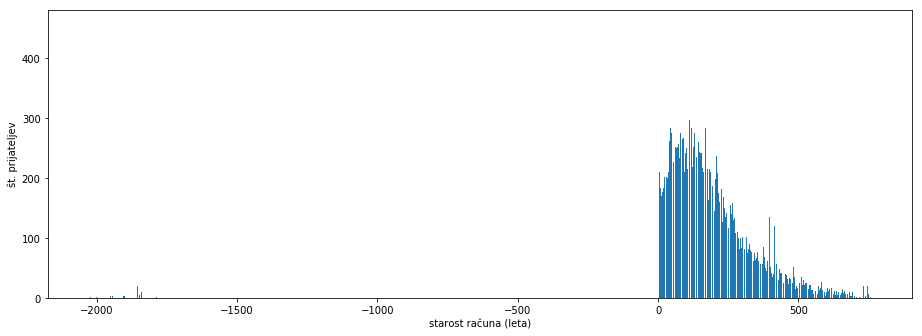

In [37]:
graph = collections.defaultdict(int)
today = datetime.datetime.now()

for player_id in global_player_ids:
    try:
        #time_created = datetime.datetime.fromtimestamp(int(players_summaries[player_id]["timecreated"]))
        time_created = int(players_summaries[player_id]["timecreated"])
    except KeyError:
        continue
    
    for tmp_friend in player_friends[player_id]:
        time_diff = tmp_friend["friend_since"] - time_created
        weeks = round(time_diff / (3600 * 24 *7))
        
        if weeks < 0:
            print(datetime.datetime.fromtimestamp(time_created), "|||"
        
        # If the player made this friend in the first year (since the account was created)
        #if time_diff <= (3600 * 24 * 365):
        graph[weeks] += 1
    
    """
    years = today.year - time_created.year
    if today.month < time_created.month or (today.month == time_created.month and today.day < time_created.day):
        years -= 1
        
    try:
        last_log = players_summaries[player_id]["lastlogoff"]
        time_last_log = datetime.datetime.fromtimestamp(int(last_log))
    except KeyError:
        continue

    if years not in graph:
        graph[years] = [len(player_friends[player_id]), 1]
    else:
        su, cnt = graph[years]
        graph[years] = [su + len(player_friends[player_id]), cnt+1]
    """

graph_x = []
graph_y = []

for week in sorted(graph):
    graph_x += [week]
    graph_y += [graph[week]]

"""
for dat in sorted(graph.items()):
    graph_x += [dat[0]]
    graph_y += [dat[1][0]/dat[1][1]]
"""
    
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 2, 1])
axes.bar(graph_x, graph_y)
axes.set_ylabel('št. prijateljev')
axes.set_xlabel('starost računa (leta)')
#axes.set_title('Primerjava žanrov ter njihovih ocen');

## 5. Odvisnost med težavnostjo igre in njenim uspehom